In [114]:
# train
import pandas as pd
import datetime as dt
import os
import numpy as np
import pandas as pd
import os
import torch
from torch import optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from models import Informer, Autoformer, Transformer, DLinear, Linear, NLinear
from sklearn.preprocessing import StandardScaler
from utils.timefeatures import time_features
import warnings
import argparse

parser = argparse.ArgumentParser(description='Autoformer & Transformer family for Time Series Forecasting')


# # basic config
# parser.add_argument('--is_training', type=int, required=True, default=1, help='status')
parser.add_argument('--train_only', type=bool, required=False, default=False, help='perform training on full input dataset without validation and testing')
# parser.add_argument('--model_id', type=str, required=True, default='test', help='model id')
# parser.add_argument('--model', type=str, required=True, default='Autoformer',
#                     help='model name, options: [Autoformer, Informer, Transformer]')

# data loader
# parser.add_argument('--data', type=str, required=True, default='ETTm1', help='dataset type')
parser.add_argument('--root_path', type=str, default='./data/ETT/', help='root path of the data file')
parser.add_argument('--data_path', type=str, default='ETTh1.csv', help='data file')
parser.add_argument('--features', type=str, default='M',
                    help='forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate')
parser.add_argument('--target', type=str, default='OT', help='target feature in S or MS task')
parser.add_argument('--freq', type=str, default='h',
                    help='freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h')
parser.add_argument('--checkpoints', type=str, default='./checkpoints/', help='location of model checkpoints')

# forecasting task
parser.add_argument('--seq_len', type=int, default=96, help='input sequence length')
parser.add_argument('--label_len', type=int, default=48, help='start token length')
parser.add_argument('--pred_len', type=int, default=96, help='prediction sequence length')


# DLinear
parser.add_argument('--individual', action='store_true', default=False, help='DLinear: a linear layer for each variate(channel) individually')
# Formers 
parser.add_argument('--embed_type', type=int, default=0, help='0: default 1: value embedding + temporal embedding + positional embedding 2: value embedding + temporal embedding 3: value embedding + positional embedding 4: value embedding')
parser.add_argument('--enc_in', type=int, default=7, help='encoder input size') # DLinear with --individual, use this hyperparameter as the number of channels
parser.add_argument('--dec_in', type=int, default=7, help='decoder input size')
parser.add_argument('--c_out', type=int, default=7, help='output size')
parser.add_argument('--d_model', type=int, default=512, help='dimension of model')
parser.add_argument('--n_heads', type=int, default=8, help='num of heads')
parser.add_argument('--e_layers', type=int, default=2, help='num of encoder layers')
parser.add_argument('--d_layers', type=int, default=1, help='num of decoder layers')
parser.add_argument('--d_ff', type=int, default=2048, help='dimension of fcn')
parser.add_argument('--moving_avg', type=int, default=25, help='window size of moving average')
parser.add_argument('--factor', type=int, default=1, help='attn factor')
parser.add_argument('--distil', action='store_false',
                    help='whether use distilling in encoder, using this argument means not using distilling',
                    default=True)
parser.add_argument('--dropout', type=float, default=0.05, help='dropout')
parser.add_argument('--embed', type=str, default='timeF',
                    help='time features encoding, options:[timeF, fixed, learned]')
parser.add_argument('--activation', type=str, default='gelu', help='activation')
parser.add_argument('--output_attention', action='store_true', help='whether to output attention in ecoder')
parser.add_argument('--do_predict', action='store_true', help='whether to predict unseen future data')

# optimization
parser.add_argument('--num_workers', type=int, default=0, help='data loader num workers')
parser.add_argument('--itr', type=int, default=2, help='experiments times')
parser.add_argument('--train_epochs', type=int, default=10, help='train epochs')
parser.add_argument('--batch_size', type=int, default=32, help='batch size of train input data')
parser.add_argument('--patience', type=int, default=3, help='early stopping patience')
parser.add_argument('--learning_rate', type=float, default=0.0001, help='optimizer learning rate')
parser.add_argument('--des', type=str, default='test', help='exp description')
parser.add_argument('--loss', type=str, default='mse', help='loss function')
parser.add_argument('--lradj', type=str, default='type1', help='adjust learning rate')
parser.add_argument('--use_amp', action='store_true', help='use automatic mixed precision training', default=False)

# GPU
parser.add_argument('--use_gpu', type=bool, default=True, help='use gpu')
parser.add_argument('--gpu', type=int, default=0, help='gpu')
parser.add_argument('--use_multi_gpu', action='store_true', help='use multiple gpus', default=False)
parser.add_argument('--devices', type=str, default='0,1,2,3', help='device ids of multile gpus')
parser.add_argument('--test_flop', action='store_true', default=False, help='See utils/tools for usage')

args = parser.parse_args([])

class Dataset_Game1(Dataset):
    def __init__(self, split = 'train', scale = True):
        self.seq_len = 4 * 4
        self.label_len = 4
        self.pred_len = 4
        self.split = split
        self.dataset = []
        self.scale = scale
        self.data_stamp = np.array([[i for i in range(40)]]).T
        self.get_dataset()
        
    def get_dataset(self):
        df_raw = pd.read_csv('./dataset/CXDSheet1.csv')
        df_raw['date'] = [i for i in range(48546)]
        df_raw['date'] = pd.to_timedelta(df_raw['date'], unit='d') + pd.datetime(1889,7,2)
        df_raw['date']
        
    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len
        
        seq_x = self.dataset[index][:self.seq_len]
        seq_y = self.dataset[index][self.seq_len - self.label_len:]
        seq_x_mark = self.data_stamp[index % 20:index % 20 + self.seq_len]
        seq_y_mark = self.data_stamp[index % 20:index % 20 + self.label_len + self.pred_len]
        return seq_x, seq_y, seq_x_mark, seq_y_mark
    
    def __len__(self):
        return len(self.dataset)
    

def adjust_learning_rate(optimizer, epoch, args):
    # lr = args.learning_rate * (0.2 ** (epoch // 2))
    if args.lradj == 'type1':
        lr_adjust = {epoch: args.learning_rate * (0.5 ** ((epoch - 1) // 1))}
    elif args.lradj == 'type2':
        lr_adjust = {
            2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
            10: 5e-7, 15: 1e-7, 20: 5e-8
        }
    elif args.lradj == '3':
        lr_adjust = {epoch: args.learning_rate if epoch < 10 else args.learning_rate*0.1}
    elif args.lradj == '4':
        lr_adjust = {epoch: args.learning_rate if epoch < 15 else args.learning_rate*0.1}
    elif args.lradj == '5':
        lr_adjust = {epoch: args.learning_rate if epoch < 25 else args.learning_rate*0.1}
    elif args.lradj == '6':
        lr_adjust = {epoch: args.learning_rate if epoch < 5 else args.learning_rate*0.1}  
    if epoch in lr_adjust.keys():
        lr = lr_adjust[epoch]
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        print('Updating learning rate to {}'.format(lr))

In [106]:

df_raw = pd.read_csv('./dataset/rain.csv')
df_raw['date'] = [i+0.0 for i in range(48546)]
df_raw['date'] = pd.to_timedelta(df_raw['date'], unit='d') + pd.datetime(1889,7,2)
df_raw.to_csv('./dataset/rain1.csv', index=False)

C:\Users\L\AppData\Local\Temp\ipykernel_25480\2116497737.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  df_raw['date'] = pd.to_timedelta(df_raw['date'], unit='d') + pd.datetime(1889,7,2)


In [ ]:
# train on linear
train_set = Dataset_Game1(split='train')
train_loader = DataLoader(train_set, batch_size=8, shuffle=True)

args.seq_len = 16
args.pred_len = 4
args.label_len = 4
args.channels = 3
args.individual = False
model = Linear.Model(args).float().cuda()
model_optim = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()
model.train()
train_steps = len(train_loader)
for epoch in range(10000):
    train_loss = []
    for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(train_loader):
           
        # visualize data
        # agent_keys = [i for i in range(3)]  
        # for idx in range(len(agent_keys)):
        #     plt.plot([i for i in range(16)], [batch_x[0][i][idx] for i in range(16)], label = agent_keys[idx])
        # plt.legend()
        # break
        
        model_optim.zero_grad()
        batch_x = batch_x.float().cuda()
        batch_y = batch_y.float().cuda()
        
        # encoder - decoder
        outputs = model(batch_x)
        f_dim = 0
        outputs = outputs[:, -args.pred_len:, f_dim:]
        batch_y = batch_y[:, -args.pred_len:, f_dim:].cuda()
        loss = criterion(outputs, batch_y)
        train_loss.append(loss.item())
        
        loss.backward()
        model_optim.step()
        
    train_loss = np.average(train_loss)
    lr = 1e-4 * (0.999 ** (epoch // 2))
    for param_group in model_optim.param_groups:
        param_group['lr'] = lr
    if epoch % 100 == 0:
        print("Epoch: {0}, Steps: {1} | Train Loss: {2:.7f}".format(
            epoch, train_steps, train_loss))
        print('Updating learning rate to {}'.format(lr))
    



[[-0.24189386]]
1.0596828346946763
222.76617601471062


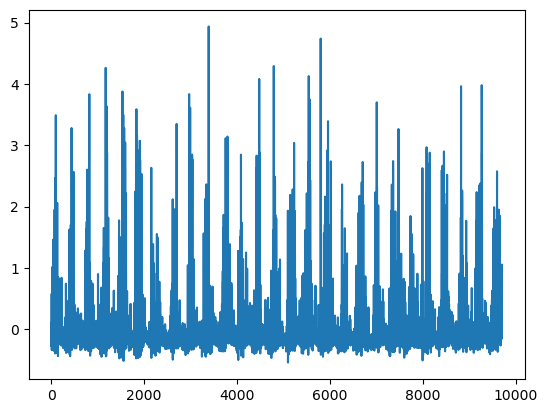

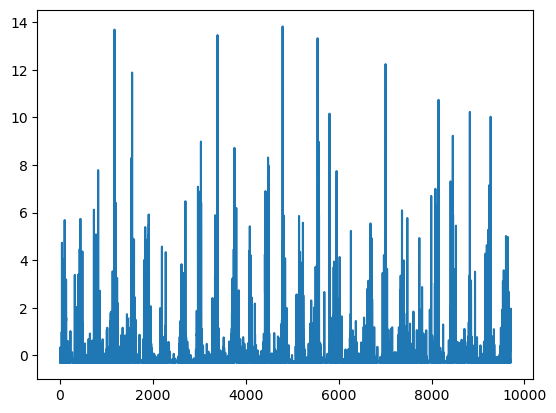

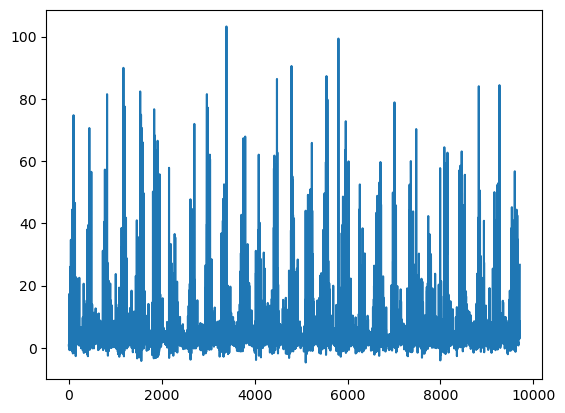

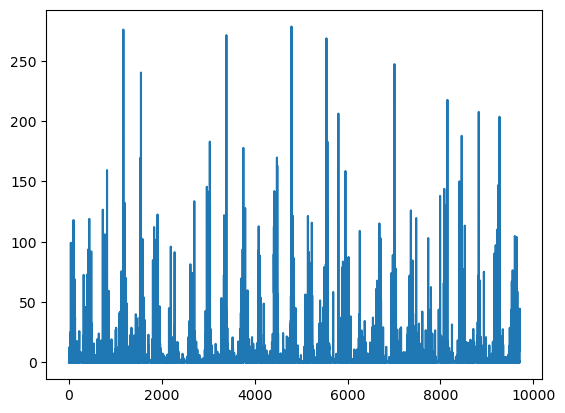

In [157]:
from matplotlib import pyplot as plt
preds = np.load('./results/rain_7_1_Informer_custom_ftMS_sl7_ll3_pl1_dm512_nh8_el2_dl1_df2048_fc3_ebtimeF_dtTrue_Exp_0/pred.npy')
trues = np.load('./results/rain_7_1_Informer_custom_ftMS_sl7_ll3_pl1_dm512_nh8_el2_dl1_df2048_fc3_ebtimeF_dtTrue_Exp_0/true.npy')
scaler = StandardScaler()
df = pd.read_csv('./dataset/rain.csv')
scaler.fit(df['OT'][:int(0.7 * len(df))].values.reshape(-1,1))
OT = scaler.transform(df['OT'].values.reshape(-1,1))
plt.figure()
plt.plot([i for i in range(9709)], preds.reshape(-1))
plt.figure()
plt.plot([i for i in range(9709)], OT[-9709:].reshape(-1))
print(np.average(torch.tensor(preds.reshape(-1) - OT[-9709:]).pow(2)))
preds = scaler.inverse_transform(preds.reshape(-1,1))
plt.figure()
plt.plot([i for i in range(9709)], preds.reshape(-1))
plt.figure()
plt.plot([i for i in range(9709)], df['OT'][-9709:].values.reshape(-1))
print(np.average((preds.reshape(-1) - df['OT'][-9709:]).pow(2)))

In [172]:
print(scaler.mean_, scaler.var_)

[5.968114] [388.30268296]


In [176]:
OT[-9709]

array([-0.30286697])